In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_FILE = 'CWRU_train.csv'
TARGET = 'Fault type'
ENCODED_TARGET = 'Encoded fault type'

Load data.

In [62]:
train_df = pd.read_csv(DATA_FILE)

Build pipeline for preprocessing and training. 

In [63]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_features = train_df.columns.tolist()
to_remove = [TARGET, ENCODED_TARGET]
numerical_features = [x for x in numerical_features if x not in to_remove]

imputer_numerical = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
pipe_numerical = Pipeline([('imputer', imputer_numerical),
                           ('scaler', std_scaler)])

# Create ColumnTransformer
col_transformer = ColumnTransformer([
    ('num_preproc', pipe_numerical, numerical_features)])

Find optimal parameters for SVM classifier.

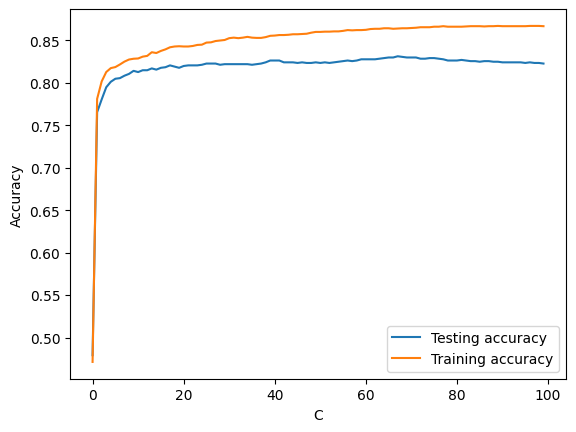

Optimal C: 67
Max test accuracy: 0.8311874105865522


In [64]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

x = train_df.drop([TARGET], axis=1)
x = x.drop([ENCODED_TARGET], axis=1)
y = train_df[ENCODED_TARGET]
y = y.to_frame(name=ENCODED_TARGET)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

c_svm = np.arange(0.01, 100)
train_accuracy = np.empty(len(c_svm))  # arrays to store training and test accuracies
test_accuracy = np.empty(len(c_svm))

for i, k in enumerate(c_svm):
    model = SVC(C=k)
    pipe = Pipeline([('preproc', col_transformer),
                           ('model', model)])
    pipe.fit(x_train, y_train.values.ravel())
    train_accuracy[i] = pipe.score(x_train, y_train)
    test_accuracy[i] = pipe.score(x_test, y_test)

plt.plot(c_svm, test_accuracy, label='Testing accuracy')
plt.plot(c_svm, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

print(f"Optimal C: {np.argmax(test_accuracy)}")  # print optimal C and max test accuracy
print(f"Max test accuracy: {max(test_accuracy)}")


Build and evaluate best SVM classifier. 

Best model training accuracy: 0.8666053357865685
Best model test accuracy: 0.8226037195994278


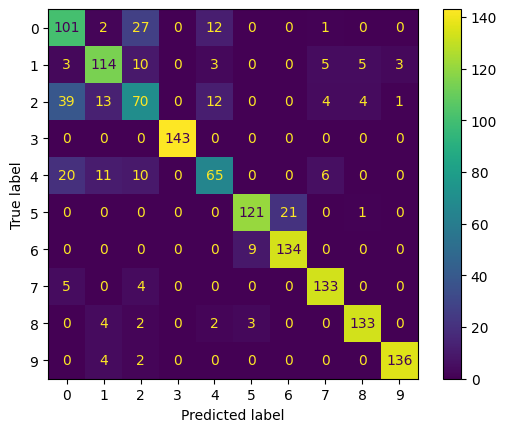

In [65]:
best_model = SVC(C=c_svm[np.argmax(test_accuracy)])
pipe_final = Pipeline([('preproc', col_transformer), 
                 ('model', model)])
pipe_final.fit(x_train, y_train.values.ravel())

train_accuracy_final = pipe.score(x_train, y_train)
test_accuracy_final = pipe.score(x_test, y_test)

print(f"Best model training accuracy: {train_accuracy_final}")
print(f"Best model test accuracy: {test_accuracy_final}")

# Plot confusion matrix
cm = confusion_matrix(y_test, pipe.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()